# AutoTST

## Import Necessary Modules

In [1]:
import os
import sys
import logging

import re
import imp
import itertools
import cPickle as pickle
import pandas as pd

# do this before we have a chance to import openbabel!
import rdkit, rdkit.Chem, rdkit.Chem.rdDistGeom, rdkit.DistanceGeometry

from rmgpy.molecule import Molecule
from rmgpy.species import Species
from rmgpy.reaction import Reaction
from rmgpy.kinetics import PDepArrhenius, PDepKineticsModel

from rmgpy.data.rmg import RMGDatabase
from rmgpy.data.kinetics import KineticsDepository, KineticsRules

In [2]:
from rmgpy.qm.main import QMCalculator
from rmgpy.qm.reaction import *

In [3]:
rxnFamilies = ['H_Abstraction']  # Only looking at H_abstraction via OOH

print 'Loading RMG Database ...'

rmgDatabase = RMGDatabase()
databasePath = os.path.abspath(os.path.join(os.getenv('RMGpy', '..'), "..", 'RMG-database', 'input'))
logging.info(databasePath)
rmgDatabase.load(databasePath,
                 kineticsFamilies=rxnFamilies,
                 transportLibraries=[],
                 reactionLibraries=[],
                 seedMechanisms=[],
                 thermoLibraries=['primaryThermoLibrary', 'KlippensteinH2O2', 'thermo_DFT_CCSDTF12_BAC', 'CBS_QB3_1dHR' ], #'KlippensteinH2O2' ],
                 solvation=False,
                 )
print 'RMG Database Loaded'

Loading RMG Database ...
RMG Database Loaded


In [64]:
#oohReaction = eval('Reaction(reactants=[Species(label="H2O2", molecule=[Molecule(SMILES="OO")]), Species(label="H", molecule=[Molecule(SMILES="[H]")])], products=[Species(label="HO2", molecule=[Molecule(SMILES="[O]O")]), Species(label="H2", molecule=[Molecule(SMILES="[H][H]")])])')
reactants = [Species(molecule=[Molecule(SMILES = "CCCC")]), Species(molecule=[Molecule(SMILES = "[O]O")])]
products = [Species(molecule=[Molecule(SMILES = "[CH2]CCC")]), Species(molecule=[Molecule(SMILES = "OO")])]
oohReaction = Reaction(reactants=reactants, products=products)
""
rxnFamily = "H_Abstraction"
rSpecies1, rSpecies2 = oohReaction.reactants
pSpecies1, pSpecies2 = oohReaction.products

rSpecies1.generateResonanceIsomers()
rSpecies2.generateResonanceIsomers()
pSpecies1.generateResonanceIsomers()
pSpecies2.generateResonanceIsomers()

In [65]:
oohReaction

['#!/usr/bin/env python\n',
 '# encoding: utf-8\n',
 '\n',
 'name = "H_Abstraction/TS_groups"\n',
 'shortDesc = u""\n',
 'longDesc = u"""\n',
 '\n',
 '"""\n',
 '\n',
 'entry(\n',
 '    index = 1,\n',
 '    label = "X_H_or_Xrad_H_Xbirad_H_Xtrirad_H",\n',
 '    group = "OR{H2, C_H, O_H}",\n',
 '    distances = DistanceData(\n',
 "        distances = {'d12': 1.29715, 'd13': 2.57849, 'd23': 1.29649},\n",
 "        uncertainties = {'d12': 0.112158, 'd13': 0.077474, 'd23': 0.112405},\n",
 '    ),\n',
 '    shortDesc = u"""Fitted to 2490 distances.\n',
 '""",\n',
 '    longDesc = \n',
 'u"""\n',
 '[<Entry index=118 label="C/H3/Cs">, <Entry index=262 label="Cdj_CdsCs">]\n',
 '[<Entry index=43 label="C_methane">, <Entry index=212 label="Csj/Cs/Cs/H">]\n',
 '[<Entry index=119 label="C/H3/Cd">, <Entry index=36 label="Cbj">]\n',
 '[<Entry index=172 label="Csrad/H/Ct/H">, <Entry index=6 label="Hrad">]\n',
 '[<Entry index=122 label="C/H2/Cs/Cs">, <Entry index=260 label="Cdj_CdsH">]\n',
 '[<Entry ind

In [72]:
testReaction = Reaction(reactants=[rSpecies1, rSpecies2], products=[pSpecies1, pSpecies2], reversible=True)
reactionList = []
for moleculeA in rSpecies1.molecule:
    for moleculeB in rSpecies2.molecule:
        tempList = rmgDatabase.kinetics.generateReactionsFromFamilies([moleculeA, moleculeB], [], only_families=[rxnFamily])
        for rxn0 in tempList:
            reactionList.append(rxn0)
            
reactionList

ERROR:root:Problem family: H_Abstraction
ERROR:root:Problem reactants: [Molecule(SMILES="CCCC"), Molecule(SMILES="[O]O")]


AttributeError: 'rmgpy.species.Species' object has no attribute 'item'

In [62]:
for reaction in reactionList:
    # Check if any of the RMG proposed reactions matches the reaction in the mechanism
    if testReaction.isIsomorphic(reaction):
        # Now add the labeled atoms to the Molecule, and check all labels were added
        atLblsR = dict([(lbl[0], False) for lbl in reaction.labeledAtoms])
        atLblsP = dict([(lbl[0], False) for lbl in reaction.labeledAtoms])

        for reactant in reaction.reactants:

            reactant.clearLabeledAtoms()
            for atom in reactant.atoms:
                for atomLabel in reaction.labeledAtoms:
                    if atom==atomLabel[1]:
                        atom.label = atomLabel[0]
                        atLblsR[atomLabel[0]] = True
        for product in reaction.products:

            product.clearLabeledAtoms()
            for atom in product.atoms:
                for atomLabel in reaction.labeledAtoms:
                    if atom==atomLabel[1]:
                        atom.label = atomLabel[0]
                        atLblsP[atomLabel[0]] = True
        if all( atLblsR.values() ) and all( atLblsP.values() ):
            gotOne=True
            break
reaction

NameError: name 'reactionList' is not defined

In [6]:
#import py3Dmol
from rmgpy.qm.main import QMCalculator
from rmgpy.qm.reaction import *
from rmgpy.qm.main import QMSettings

def view_mol(rdkit_mol):
    """
    A method designed to create a 3D figure of the Multi_Molecule with py3Dmol
    """
    from rdkit import Chem
    mb  = Chem.MolToMolBlock(rdkit_mol)
    p = py3Dmol.view(width=400, height=400)
    p.addModel(mb, "sdf")
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p.show()

In [61]:
reaction

NameError: name 'reaction' is not defined

In [71]:
a = rmgDatabase.kinetics.families['H_Abstraction']
q = a.loadTemplate(oohReaction.reactants, oohReaction.products)
q

In [44]:
from rmgpy.data.kinetics.transitionstates import *

from rmgpy.kinetics import Arrhenius, ArrheniusEP, ThirdBody, Lindemann, Troe, \
                           PDepArrhenius, MultiArrhenius, MultiPDepArrhenius, \
                           Chebyshev, KineticsData

TransitionStates().load("database/H_Abstraction/", {
            'KineticsData': KineticsData,
            'Arrhenius': Arrhenius,
            'ArrheniusEP': ArrheniusEP,
            'MultiArrhenius': MultiArrhenius,
            'MultiPDepArrhenius': MultiPDepArrhenius,
            'PDepArrhenius': PDepArrhenius,
            'Chebyshev': Chebyshev,
            'ThirdBody': ThirdBody,
            'Lindemann': Lindemann,
            'Troe': Troe,
            'R': constants.R,
        }, {})

AttributeError: 'NoneType' object has no attribute 'forwardTemplate'

In [18]:
TransitionStates().load("database/H_Abstraction/", local_context = {"TS_groups":None} , global_context={"TS_groups":None})

AttributeError: 'NoneType' object has no attribute 'forwardTemplate'

In [7]:
settings = QMSettings(
    software='gaussian',
    method='m062x',
    fileStore=os.path.expandvars('.'),
    scratchDirectory=os.path.expandvars('.'),
    )

tsDatabase = rmgDatabase.kinetics.families["H_Abstraction"].transitionStates
tsDatabase

<rmgpy.data.kinetics.transitionstates.TransitionStates instance at 0x11f5c0ef0>

In [25]:
rxn = QMReaction(reaction=reaction, settings=settings, tsDatabase=tsDatabase)
rxn

<rmgpy.qm.reaction.QMReaction instance at 0x112e0ea28>

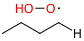

In [26]:
reacts, products = rxn.setupMolecules()
reacts

In [27]:
rdkit_mol, bm, rxn.reactantGeom =  rxn.generateBoundsMatrix(reacts)
view_mol(rdkit_mol)

In [30]:
labels, atom_match = rxn.getLabels(reacts)
labels, atom_match

([2, 8, 15], ((2,), (8,), (15,)))

In [33]:
bm = rxn.editMatrix(reacts, bm, labels)
bm

array([[  0.00000000e+00,   1.52400000e+00,   1.52400000e+00,
          2.51279063e+00,   1.11940079e+00,   1.11940079e+00,
          2.19506659e+00,   2.19506659e+00,   2.19506659e+00,
          2.19506659e+00,   2.19506659e+00,   3.43890609e+00,
          3.43890609e+00,   3.43890609e+00,   1.00000000e+03,
          1.00000000e+03,   1.00000000e+03],
       [  1.50400000e+00,   0.00000000e+00,   2.51279063e+00,
          1.52400000e+00,   2.19506659e+00,   2.19506659e+00,
          1.11940079e+00,   1.11940079e+00,   3.43890609e+00,
          3.43890609e+00,   3.43890609e+00,   2.19506659e+00,
          2.19506659e+00,   2.19506659e+00,   1.00000000e+03,
          1.00000000e+03,   1.00000000e+03],
       [  1.50400000e+00,   2.43279063e+00,   0.00000000e+00,
          3.81071948e+00,   2.19506659e+00,   2.19506659e+00,
          3.43890609e+00,   3.43890609e+00,   1.39040100e+00,
          1.11940079e+00,   1.11940079e+00,   1.00000000e+03,
          1.00000000e+03,   1.00000000e+03

In [36]:
reacts = rxn.reactantGeom.rd_embed(rdkit_mol, 1000, bm=bm, match=atom_match)[0]
view_mol(reacts)

In [39]:
qmCalc = QMCalculator(
                        software='gaussian',
                        method='m062x',
                        fileStore=os.path.expandvars('.'),
                        scratchDirectory=os.path.expandvars('.'))

r = qmCalc.getKineticData(reaction, tsDatabase)

Exception: Couldn't find Gaussian executable at (Gaussian 2003 or 2009). Try setting your GAUSS_EXEDIR environment variable.

In [ ]:
for reaction in reactionList:
    # Check if any of the RMG proposed reactions matches the reaction in the mechanism
    if testReaction.isIsomorphic(reaction):
        # Now add the labeled atoms to the Molecule, and check all labels were added
        atLblsR = dict([(lbl[0], False) for lbl in reaction.labeledAtoms])
        atLblsP = dict([(lbl[0], False) for lbl in reaction.labeledAtoms])

        for reactant in reaction.reactants:

            reactant.clearLabeledAtoms()
            for atom in reactant.atoms:
                for atomLabel in reaction.labeledAtoms:
                    if atom==atomLabel[1]:
                        atom.label = atomLabel[0]
                        atLblsR[atomLabel[0]] = True
        for product in reaction.products:

            product.clearLabeledAtoms()
            for atom in product.atoms:
                for atomLabel in reaction.labeledAtoms:
                    if atom==atomLabel[1]:
                        atom.label = atomLabel[0]
                        atLblsP[atomLabel[0]] = True
        if all( atLblsR.values() ) and all( atLblsP.values() ):
            gotOne=True
            break


qmCalc = QMCalculator(
                        software='gaussian',
                        method='m062x',
                        fileStore=os.path.expandvars('/gss_gpfs_scratch/harms.n/QMfiles'),
                        scratchDirectory=os.path.expandvars('/gss_gpfs_scratch/harms.n/QMscratch'),
                        )

def calculate(reaction):
    logging.info("Calculating reaction rate for {!s}".format(reaction))
    rxnFamily = reaction.family
    logging.info("Selecting the appropriate TS distance database for family {!r}".format(rxnFamily))
    tsDatabase = rmgDatabase.kinetics.families[rxnFamily].transitionStates
    logging.info("Calculating kinetic data by calling qmCalc.getKineticData")
    reaction = qmCalc.getKineticData(reaction, tsDatabase)
    logging.info("Removing 'core*' files")
    for files in os.listdir('./'):  # This deletes any files with names starting 'core' which fill up your disk space on discovery.
        if files.startswith('core'):
            try:
                os.remove(files)
            except:
                logging.info("Error deleting files {}".format(files))
    if reaction.kinetics:
        logging.info("Yay, reaction kinetics calculated!!!")
        logging.info(repr(reaction))
    else:
        logging.info("Boo, reaction kinetics not calculated!!!")
    return reaction

def performCalcs(chemkinRxn):

    logging.info("chemkinRxn: {!r}".format(chemkinRxn))
    # Ensure all resonance isomers have been generated
    logging.info('Ensuring resonance isomers have been generated')
    for species in itertools.chain(chemkinRxn.reactants, chemkinRxn.products):
        print(type(species))
        species = species.generateResonanceIsomers()

    testReaction = Reaction(reactants=chemkinRxn.reactants, products=chemkinRxn.products, reversible=True)

    reactants = [species for species in chemkinRxn.reactants]
    # reactant_molecules is a list of lists of resonance isomers,
    # eg. a bimolecular reaction where the second reactant has 2 isomers is: [[r1],[r2i1,r2i2]]

    products = [species for species in chemkinRxn.products]
    # products is a list of molecule objects (only one resonance form of each product), eg [p1, p2]
    print reactants
    #print type(reactant_molecules[0])
    print products

    checkRxn = rmgDatabase.kinetics.generateReactionsFromFamilies(reactants, products, only_families=rxnFamilies)
    if len(checkRxn) == 1:
        logging.info("Generated one reaction:")
        logging.info(checkRxn)
        reaction = checkRxn[0]
    else:  # didn't break from for loop
        for reaction in checkRxn:
            logging.info("Generated these reactions:")
            logging.info(reaction)
            reaction = checkRxn[0]
        raise Exception("Couldn't generate exactly one reaction matching {} in family {}".format(chemkinRxn, rxnFamilies))

    logging.info("The reaction of interest is as follows: ")
    logging.info(reaction)

    logging.info("asserting that the testReaction is Isomorphic")
    assert testReaction.isIsomorphic(reaction)
    logging.info("reaction: {!r}".format(reaction))

    atLblsR = dict([(lbl[0], False) for lbl in reaction.labeledAtoms])
    atLblsP = dict([(lbl[0], False) for lbl in reaction.labeledAtoms])

    gotOne = False
    logging.info("Labeling reactant atoms")
    for reactant in reaction.reactants:
        reactant = reactant
        reactant.clearLabeledAtoms()
        for atom in reactant.atoms:
            for atomLabel in reaction.labeledAtoms:
                if atom == atomLabel[1]:
                    atom.label = atomLabel[0]
                    atLblsR[atomLabel[0]] = True

    logging.info("Labeling product atoms")
    for product in reaction.products:
        product = product
        product.clearLabeledAtoms()
        for atom in product.atoms:
            for atomLabel in reaction.labeledAtoms:
                if atom == atomLabel[1]:
                    atom.label = atomLabel[0]
                    atLblsP[atomLabel[0]] = True

    if all(atLblsR.values()) and all(atLblsP.values()):
        gotOne = True

    rxnFamily = reaction.family
    assert gotOne, "Couldn't label all the atoms using the reaction family template"

    logging.info("We have generated a {!s} reaction that matches, and used it to label the atoms.".format(rxnFamily))

    logging.info("Calculating reaction kinetics")
    reaction = calculate(reaction)

    logging.info("For reaction {0!r}".format(reaction))
    if reaction.kinetics:
        logging.info("We have calculated kinetics {0!r}".format(reaction.kinetics))

    else:
        logging.warning("Couldn't calculate kinetics.")


    if reaction.kinetics and False:
        """
        Return the rate coefficient in the appropriate combination of cm^3,
        mol, and s at temperature `T` in K and pressure `P` in Pa.
        """
        importKin = chemkinRxn['rmgPyKinetics']
        Temp = 1000  # Kelvin
        idx = str(i)
        row = [idx, rxnFamily]
        row.extend([mol.label for mol in reaction.reactants])
        row.extend([mol.label for mol in reaction.products])

        rateCal = reaction.calculateTSTRateCoefficient(Temp)
        row.extend(['AutoTST_fwd', str(rateCal)])

        if isinstance(importKin, PDepArrhenius) or isinstance(importKin, PDepKineticsModel):
            row.extend([smiles_dict[entry], str(importKin.getRateCoefficient(Temp, 1000000))])  #1000000 Pa = 10 bar
        else:
            row.extend([smiles_dict[entry], str(importKin.getRateCoefficient(Temp))])

        famDatabase = rmgDatabase.kinetics.families[rxnFamily]
        famDatabase.addKineticsRulesFromTrainingSet(thermoDatabase=rmgDatabase.thermo)
        famDatabase.fillKineticsRulesByAveragingUp()

        # Using the `testReaction` will keep the reaction direction the same as the model
        rxnTemplate = famDatabase.getReactionTemplate(testReaction)
        kList = famDatabase.getKinetics(testReaction, rxnTemplate)

        allRates = []
        kComments = []
        for rate in kList:
            k = rate[0]
            if k:
                label = rate[1]
                if isinstance(label, KineticsDepository):
                    label = label.label
                elif isinstance(label, KineticsRules):
                    label = label.label
                if label.lower() == 'rate rules':
                    kComments = k.comment.split('\n')
                allRates.append((label, k.getRateCoefficient(Temp)))

        kDict = {'Rate Rules': []}
        for kTuple in allRates:
            if kTuple[0] == 'AutoTST':
                kDict['AutoTST'] = kDict['AutoTST'] + [kTuple[1]]
            elif kTuple[0] == 'rate rules':
                kDict['Rate Rules'] = kDict['Rate Rules'] + [kTuple[1]]
            elif kTuple[0].endswith('/NIST'):
                kDict['NIST'] = kDict['NIST'] + [kTuple[1]]
            elif kTuple[0].endswith('/rules'):
                kDict['KineitcsRules'] = kDict['KineitcsRules'] + [kTuple[1]]

        # Print the values in order
        kineticsTypes = ['Rate Rules']  #['AutoTST', 'Rate Rules', 'NIST', 'KineitcsRules']
        for kinType in kineticsTypes:
            row.append(kinType)
            if kDict[kinType] == []:
                row.append('no Val')
            else:
                for val in kDict[kinType]:
                    row.append(str(val))

        # Store line containing reaction from corresponding chemkin file
        row.append(smiles_dict[entry])
        row.append(chemkinRxn['chemkinKinetics'].strip())

        # Store rmgpy kinetics group comments
        row = row + kComments

        folderPath = os.path.join('KinTxtFiles', idx)

        if not os.path.exists(folderPath):
            os.makedirs(folderPath)

        input_string = ','.join(row)
        with open(os.path.join(folderPath, smiles_dict[entry] + '_kinetics.txt'), 'w') as kinTxt:
                kinTxt.write(input_string)



rxn = reactionList[0]
performCalcs(rxn)